In [1]:
import numpy as np
from scipy.linalg import sqrtm
import qiskit
import random
import matplotlib.pyplot as plt

from qiskit.quantum_info import Statevector
from qiskit.extensions import HamiltonianGate
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, assemble, Aer, IBMQ, execute

from qiskit.algorithms.linear_solvers.numpy_linear_solver import NumPyLinearSolver
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.algorithms.linear_solvers.matrices import TridiagonalToeplitz
from qiskit.algorithms.linear_solvers.observables import MatrixFunctional
from scipy.optimize import curve_fit
from qiskit.visualization import plot_histogram, plot_bloch_multivector
n_qubits=5

In [2]:
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
sigma=np.array([np.eye(2,dtype="complex"),X,Y,Z])
I=np.eye(2,dtype="complex")
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])

In [3]:
def get_psi(n_qubits): #Random state Haar measure
    psi = np.reshape(np.array([np.random.normal() for i in range(2**n_qubits)]) + 1j*np.array([np.random.normal() for i in range(2**n_qubits)]), (2**n_qubits,1))
    psi=psi/(np.sqrt(psi.conjugate().T@psi))
    return psi
def equal(a,b):
    return np.linalg.norm(a-b)<0.000001 #проверка равентства матриц
def is_unitary(matrix):
    if(np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))<0.00001):
        return True
    return np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
def is_hermit(matrix):
    return np.linalg.norm(matrix.T.conjugate()-matrix)<0.0000001
def trace(a):
    return np.trace(a)/len(a)
def convert_base(value, base, length=16,n_qubits=n_qubits):# меняет систему исчесления
    if value < 0:
        value = ( 1<<length ) + value
 
    res = ''
    while value > 0:
        res = str(value % base) + res
        value //= base
    while len(res)<n_qubits:
        res="0"+res
    return res
def decompose(A,n_qubits=n_qubits): # разложение на строчки Паули
    parameters=np.array([])
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        parameters=np.append(parameters,trace(A@a))
    return parameters
def compose(parameters,n_qubits=n_qubits): # сборка по параметрам разложения
    A=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        A=A+parameters[i]*a
    return A
def Pauli_system(a):
    Pauli_string=''
    for i in range(len(a)):
        if a[i]=='0':
            Pauli_string+="I"
        if a[i]=="1":
            Pauli_string+="X"
        if a[i]=="2":
            Pauli_string+="Y"
        if a[i]=="3":
            Pauli_string+="Z"
    return Pauli_string 
def write_decomposition(parameters,n_qubits=n_qubits):
    a=""
    for i in range(len(parameters)):
        if parameters[i]!=0:
            if np.imag(parameters[i])==0:
                if np.real(parameters[i])>0:
                    print("+ "+str(np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            elif np.real(parameters[i])==0:
                if np.imag(parameters[i])>0:
                    print("+ "+str(np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ") 
            else:
                if np.imag(parameters[i])>0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"+ "+str(np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])<0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"- "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])>0 and np.real(parameters[i])<0:
                    print("+ (-"+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- ("+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
def Unitaries(decomposition,n_qubits=n_qubits):
    Unit=np.eye(2**n_qubits,dtype="complex")
    for i in range(1,len(decomposition)):
        if decomposition[i]!=0:
            a=sigma[int(convert_base(i,4)[0])]
            for j in range(1,n_qubits):
                a=np.kron(a,sigma[int(convert_base(i,4)[j])])
            Unit=np.append(Unit,a,axis=0)
    return np.reshape(Unit,(len(decomposition[decomposition!=0]),2**n_qubits,2**n_qubits))
def h_decompose(matrix): #decompose a matrix to sum of the 2 hermitian operators
    H1=0.5*(matrix+matrix.T.conjugate())
    H2=-0.5j*(matrix-matrix.T.conjugate())
    if is_hermit(H1) and is_hermit(H2):
        return H1,H2
    else:
        return False
def u_decompose(A): #decompose a hermitian matrix to sum of 2 unitaries
    U1=A+1j*sqrtm(np.eye(len(A))-A@A)
    U2=A-1j*sqrtm(np.eye(len(A))-A@A) 
    if is_unitary(U1) and is_unitary(U2):
        return U1,U2
    else:
        return False
def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])

# Creation A

In [4]:
A=np.zeros((2**n_qubits,2**n_qubits)) #cycle
A_free=np.zeros((2**n_qubits,2**n_qubits)) #non cycle
for i in range(2**n_qubits):
    A[i][i]=-2;
    A_free[i][i]=-2
    if i!=0:
        A[i][i-1]=1
        A_free[i][i-1]=1
    if i!=2**n_qubits-1:
        A[i][i+1]=1
        A_free[i][i+1]=1
    A[0][-1]=1
    A[-1][0]=1
A_norm=np.linalg.norm(A)
A=A/np.linalg.norm(A)

# Creation b and finding x

In [5]:
val,vec=np.linalg.eigh(A)
b=np.array([random.random()*np.exp(-1j*2*np.pi*random.random())*(vec.T[i]) for i in range(2**n_qubits-1)]).sum(axis=0).reshape((2**n_qubits,1))
b=b/np.sqrt(b.T.conjugate()@b)
val=np.array([1/val[i] for i in range(len(val)-1)])
val=np.append(val,0.)
A_inv=vec@np.diag(val)@vec.T #псевдообратная
x=A_inv@b # решение
np.linalg.norm(A@x-b)<0.0000001# проверка найденного решения

True

In [6]:
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)
def L(n=n_qubits):
    matrix=np.zeros((2**n,2**n),dtype="complex")
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix     

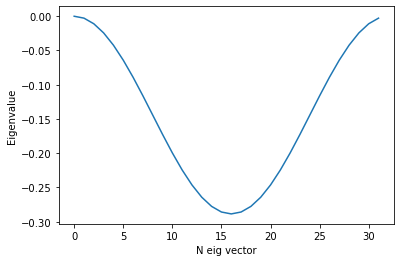

In [7]:
plt.plot(np.real(np.diag(np.round(QFT()@A@QFT().T.conjugate(),10))))
plt.xlabel("N eig vector")
plt.ylabel("Eigenvalue")
plt.show()

In [8]:
A_F=np.diag(np.array([-4*np.sin(np.pi*i/(2**n_qubits))**2 for i in range(2**n_qubits)]))

In [9]:
A_new_F=np.diag(np.array([-4+((np.pi*2/(2**n_qubits))**2)*(i-2**(n_qubits-1))**2 for i in range(2**n_qubits)]))

write_decomposition(np.round(decompose(A_new_F),3))

- 0.704 IIIII + 0.019 IIIIZ + 0.039 IIIZI + 0.039 IIIZZ + 0.077 IIZII + 0.077 IIZIZ + 0.154 IIZZI + 0.154 IZIII + 0.154 IZIIZ + 0.308 IZIZI + 0.617 IZZII + 0.308 ZIIII + 0.308 ZIIIZ + 0.617 ZIIZI + 1.234 ZIZII + 2.467 ZZIII 

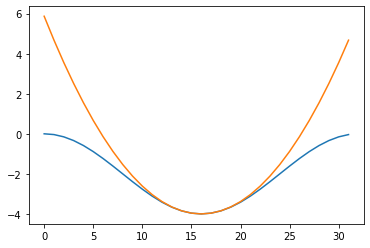

In [10]:
plt.plot(np.diag(A_F))
plt.plot(np.diag(A_new_F))